In [1]:
import sys
sys.path.append('../utils/')

import numpy as np
import pandas as pd
import pickle5 as pickle
import copy
from tqdm.notebook import tqdm

from utils import get_pairwise_p_values
from survival import survival_curves
from plotting import scna_manhattan_plot

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Arial'

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data

In [2]:
tcga_clinical_df = pd.read_csv('../data/clinical_data/tcga_train_clinical_data.csv', index_col=0)
cv_predictions_df = pd.read_excel('../data/supplemental_tables.xlsx', sheet_name='Supplementary Table 5', index_col=0)

# Figure 4A

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


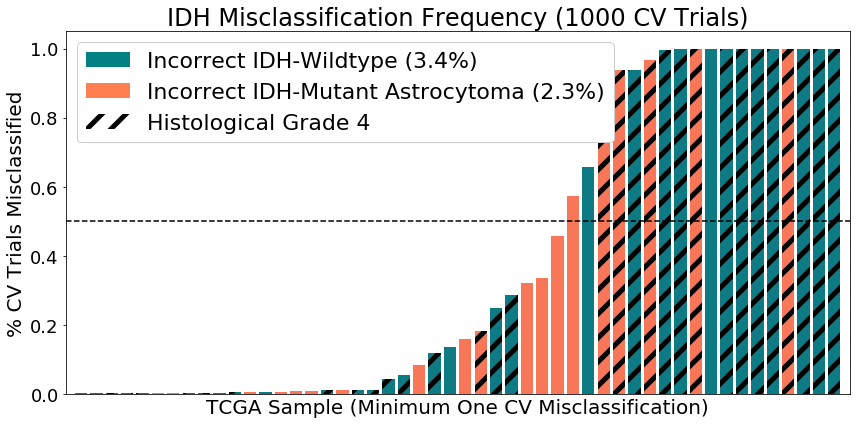

In [3]:
### find frequent misclassifed examples
_plot_df =  cv_predictions_df.loc[cv_predictions_df['Avg Misclassified'] > 0][['Avg Misclassified', 'IDH Mutation Status']]
_plot_df = pd.concat([_plot_df, tcga_clinical_df['Histologic_Grade']], axis=1, join='inner')
_plot_df = _plot_df.sort_values('Avg Misclassified').reset_index()

## make plot ##
fig, ax = plt.subplots(figsize=(12, 6))
barlist = ax.bar(_plot_df['index'], _plot_df['Avg Misclassified'])
plt.xticks(rotation = 90)
plt.axhline(y=0.5, linestyle='--', color='black')

color_dict = {'c_wt':'#2b3a41', 'w_wt':'#0e7a84', 'w_mut':'#f87758', 'c_mut':'#edca4a'}

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 5.0  # previous svg hatch linewidth
    
for i in _plot_df.loc[_plot_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma'].index:
    barlist[i].set_facecolor('teal')
    barlist[i].set_facecolor(color_dict['w_wt'])
    
for i in _plot_df.loc[_plot_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma'].index:
    barlist[i].set_facecolor('coral')
    barlist[i].set_facecolor(color_dict['w_mut'])
    
for i in _plot_df.loc[_plot_df['Histologic_Grade'] == 'G4'].index:
    barlist[i].set_hatch('/')
    barlist[i].set_linewidth(5)
    
# precentage inorrect 
# wildtype
w_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                                  & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
w_wt_prec = str(np.round((len(w_wt_idxs)/len(wt_idxs)),3)*100)[:3] + '%'

# mutant
w_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                                   & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
w_mut_prec = str(np.round(len(w_mut_idxs)/len(mut_idxs),3)*100) + '%'

import matplotlib.patches as mpatches
circ1 = mpatches.Patch( facecolor='teal',alpha=1,hatch='',label=u'Incorrect IDH-Wildtype ('+w_wt_prec+')')
circ2= mpatches.Patch( facecolor='coral',alpha=1,hatch='',label=u'Incorrect IDH-Mutant Astrocytoma ('+w_mut_prec+')')
circ3 = mpatches.Patch(facecolor='white',alpha=1,hatch='/',label='Histological Grade 4')
ax.legend(handles = [circ1,circ2,circ3], fontsize=22, bbox_to_anchor=(0.00,1), loc="upper left", framealpha=1)

plt.title('IDH Misclassification Frequency (1000 CV Trials)', fontsize=24)
plt.xlabel('TCGA Sample (Minimum One CV Misclassification)', fontsize=20)
plt.ylabel('% CV Trials Misclassified', fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=14)
plt.xticks([])
plt.xlim(-1, len(_plot_df))

plt.tight_layout()

In [4]:
w_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                                  & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
w_wt_prec = str(np.round((len(w_wt_idxs)/len(wt_idxs)),3)*100)[:3] + '%'

print(str(len(w_wt_idxs)) +'/' + str(len(wt_idxs)), w_wt_prec)

12/358 3.4%


In [5]:
w_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                                   & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
w_mut_prec = str(np.round(len(w_mut_idxs)/len(mut_idxs),3)*100) + '%'
print(str(len(w_mut_idxs)) +'/' + str(len(mut_idxs)), w_mut_prec)

6/257 2.3%


# Figure 4B

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


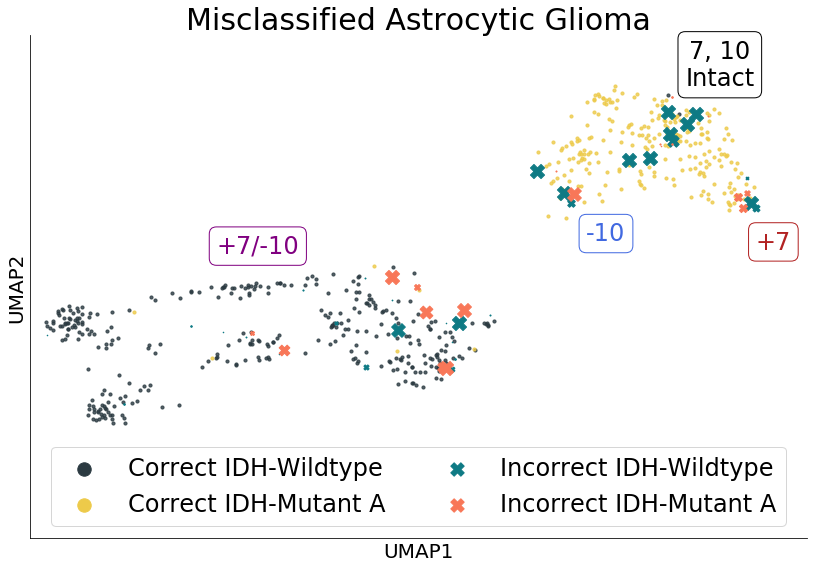

In [6]:
### Make Plot Data ###
plot_umap_df = pd.read_csv('../data/figure4/umap_astros_615.csv', index_col=0)
cv_predictions_idxs = [x for x in cv_predictions_df.index if x in plot_umap_df.index]

plot_umap_df.loc[cv_predictions_idxs, 'Avg Misclassified'] = cv_predictions_df.loc[cv_predictions_idxs]['Avg Misclassified'].values
plot_umap_df['IDH Mutation Status'] = np.nan
plot_umap_df.loc[cv_predictions_idxs, 'IDH Mutation Status'] = cv_predictions_df.loc[cv_predictions_idxs]['IDH Mutation Status'].values

### Plot ###
fig, ax = plt.subplots(figsize=(12,8))

## Correct Predictions
# wildtypes
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') & (plot_umap_df['Avg Misclassified'] == 0)]
plt.scatter(_plot_df['umap1'], _plot_df['umap2'], alpha=0.8, s=10, color=color_dict['c_wt'], marker='o', label='Correct IDH-Wildtype')

# mutants
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') & (plot_umap_df['Avg Misclassified'] == 0)]
plt.scatter(_plot_df['umap1'], _plot_df['umap2'], alpha=0.8, s=10, color=color_dict['c_mut'], marker='o', label='Correct IDH-Mutant A')
    
## IDH wildtype
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') & (plot_umap_df['Avg Misclassified'] > 0)]
for i, cnt in enumerate(_plot_df['Avg Misclassified'].unique()):
    _temp_plot_df = _plot_df.loc[_plot_df['Avg Misclassified'] == cnt]
    plt.scatter(_temp_plot_df['umap1'], _temp_plot_df['umap2'], alpha=1, s=cnt*200, color=color_dict['w_wt'], marker='X', 
                label='Incorrect IDH-Wildtype' if i == 0 else "")
    
## IDH Mutants
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') & (plot_umap_df['Avg Misclassified'] > 0)]
for i, cnt in enumerate(_plot_df['Avg Misclassified'].unique()):
    _temp_plot_df = _plot_df.loc[_plot_df['Avg Misclassified'] == cnt]
    plt.scatter(_temp_plot_df['umap1'], _temp_plot_df['umap2'], alpha=1, s=cnt*200, color=color_dict['w_mut'], marker='X', 
                label='Incorrect IDH-Mutant A' if i == 0 else "")
    
leg = plt.legend(fontsize=24, ncol=2, loc='lower center', bbox_to_anchor=(0.5, 0))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [180]

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='purple')
plt.text(x = 11.3, y=4.8, s='+7/-10', color='purple', fontsize=24, horizontalalignment='center', bbox=props)

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='royalblue')
plt.text(x = 16.5, y=5.1, s='-10', color='royalblue', fontsize=24, horizontalalignment='center', bbox=props)

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='firebrick')
plt.text(x = 19, y=4.9, s='+7', color='firebrick', fontsize=24, horizontalalignment='center', bbox=props)

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='black')
plt.text(x = 18.2, y=8.8, s='7, 10\nIntact', color='black', fontsize=24, horizontalalignment='center', bbox=props)

ax.spines['right'].set_visible(False) # ['right', 'top']
ax.spines['top'].set_visible(False) # ['right', 'top']

plt.title('Misclassified Astrocytic Glioma', fontsize=30)
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2', fontsize=20)
plt.ylim(-2,10)
plt.xlim(7.9,19.5)

plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Figure 4C

In [7]:
## data
train_chrarm_data_df = pd.read_csv('../data/chrarm_data/gdc_hg19_tcga_train_scna_chrarm_level.csv', index_col=0)

pickle_file = '../data/figure4/c_wt_dict_1000.pkl'
with open(pickle_file, 'rb') as handle:
    c_wt_sample_epoch_stats_df_dict = pickle.load(handle)
    
pickle_file = '../data/figure4/c_mut_dict_1000.pkl'
with open(pickle_file, 'rb') as handle:
    c_mut_sample_epoch_stats_df_dict = pickle.load(handle)
    
pickle_file = '../data/figure4/w_wt_dict_1000.pkl'
with open(pickle_file, 'rb') as handle:
    w_wt_sample_epoch_stats_df_dict = pickle.load(handle)
    
pickle_file = '../data/figure4/w_mut_dict_1000.pkl'
with open(pickle_file, 'rb') as handle:
    w_mut_sample_epoch_stats_df_dict = pickle.load(handle)

In [8]:
## Data for plot
sample_epoch_stats_df_dict = copy.deepcopy(c_wt_sample_epoch_stats_df_dict)
_sample_data = train_chrarm_data_df.loc[sample_epoch_stats_df_dict.keys()]
# chrom arm order
chr_arm_order = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p', '5q', '6p', '6q', '7p', '7q', '8p', '8q', 
                 '9p', '9q', '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q', 
                 '18p', '18q', '19p', '19q',  '20p', '20q', '21q', '22q']

# find averages of SHAP values (per feature/chrom arm)
_running_mean_df = pd.DataFrame(index=chr_arm_order)
_running_std_df = pd.DataFrame(index=chr_arm_order)

for sample_idx in tqdm(sample_epoch_stats_df_dict.keys()):
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idx]['Mean']
    _epoch_mean_df = pd.DataFrame(data=_epoch_mean_df.values, index=_epoch_mean_df.index, columns=[sample_idx])
    _epoch_std_df = sample_epoch_stats_df_dict[sample_idx]['STD']
    _epoch_std_df = pd.DataFrame(data=_epoch_std_df.values, index=_epoch_std_df.index, columns=[sample_idx])
    
    _running_mean_df = pd.concat([_running_mean_df, _epoch_mean_df], axis=1, join='inner')
    _running_std_df = pd.concat([_running_std_df, _epoch_std_df], axis=1, join='inner')
    
running_mean_df = _running_mean_df.mean(axis=1)
running_std_df = _running_mean_df.std(axis=1)

# find average losses and gains to color in bars in bar chart with
_data_df = _sample_data[chr_arm_order].T.mean(axis=1)
loss1_idxs = _data_df.loc[(_data_df < -0.8)].index
loss2_idxs = _data_df.loc[(_data_df < -0.6) & (_data_df >= -0.8)].index
loss3_idxs = _data_df.loc[(_data_df < -0.4) & (_data_df >= -0.6)].index
loss4_idxs = _data_df.loc[(_data_df < -0.2) & (_data_df >= -0.4)].index
loss5_idxs = _data_df.loc[(_data_df < -0.1) & (_data_df >= -0.2)].index

gain1_idxs = _data_df.loc[(_data_df > 0.8)].index
gain2_idxs = _data_df.loc[(_data_df > 0.6) & (_data_df <= 0.8)].index
gain3_idxs = _data_df.loc[(_data_df > 0.4) & (_data_df <= 0.6)].index
gain4_idxs = _data_df.loc[(_data_df > 0.2) & (_data_df <= 0.4)].index
gain5_idxs = _data_df.loc[(_data_df > 0.1) & (_data_df <= 0.2)].index

wt_shap_df = pd.concat([running_mean_df, _data_df, running_std_df], axis=1).sort_values(0).rename(columns={0:'WT_SHAP_Score',
                                                                                                  1:'WT_Arm_avg',
                                                                                                  2:'WT_STD'})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


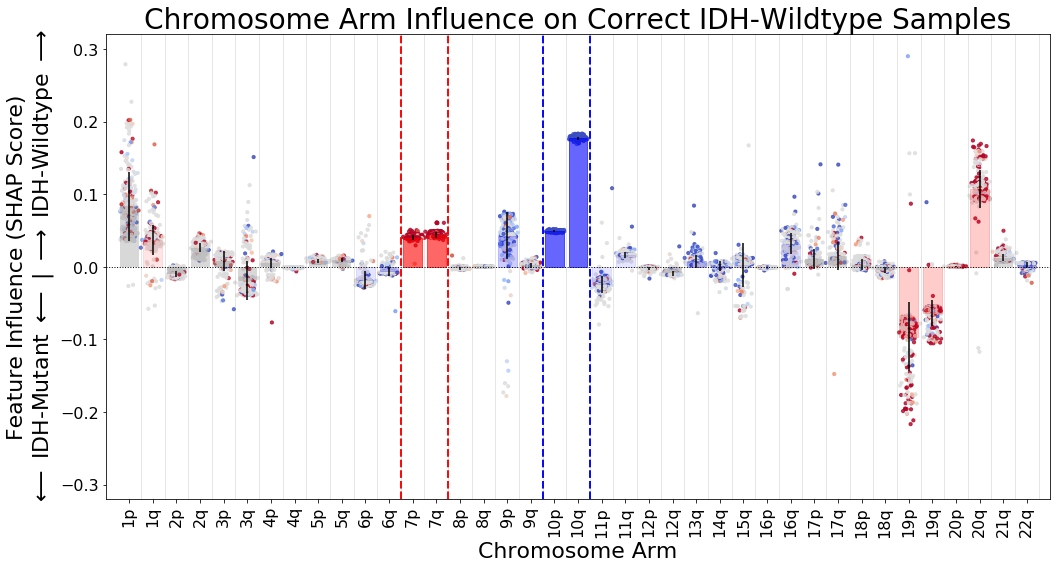

In [9]:
## SHAP Plot
fig, ax = plt.subplots(figsize=(15,8))

## Bar chart
# - running mean is the mean of all the shap values (dots) in the plot
_dict = {x:i/2+0.5 for i, x in enumerate(running_mean_df.reset_index()['index'])}
x_pos = running_mean_df.reset_index()['index'].replace(_dict)
barlist = plt.bar(x=x_pos, height=running_mean_df, yerr=running_std_df, width=0.4, facecolor="grey", alpha=0.3)


for i, chrarm in enumerate(chr_arm_order):
    if chrarm in loss1_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.6)
    elif chrarm in loss2_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.4)
    elif chrarm in loss3_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.3)
    elif chrarm in loss4_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.2)
    elif chrarm in loss5_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.1)
        
    elif chrarm in gain1_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.6)
    elif chrarm in gain2_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.4)
    elif chrarm in gain3_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.3)
    elif chrarm in gain4_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.2)
    elif chrarm in gain5_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.1)


## Scatter plot
for sample_idxs in sample_epoch_stats_df_dict.keys():
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idxs]
    _plot_df = pd.concat([_epoch_mean_df, _sample_data.T], axis=1, join='inner').reset_index()
    _plot_df['coor'] = _plot_df['index'].replace(_dict)
    _plot_df = _plot_df.iloc[::-1]
    _coors = _plot_df['coor'] + np.random.normal(0,0.075, len(_plot_df))
    plt.scatter(x=_coors, y=_plot_df['Mean'], c=_plot_df[sample_idxs], cmap="coolwarm", s=10, alpha=0.8) #vlag

## Draw Lines
for i in range(1, 22):
    plt.axvline(i-0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
    if i < 21:
        plt.axvline(i+0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
plt.axhline(0, color='black', linewidth=1, linestyle=':')

# 7 and 10 lines
plt.axvline(9.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(10.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(6.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(7.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)

# 7 and 10 lines
plt.axvline(9.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(10.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(6.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(7.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)

## Plot labels / format
plt.title('Chromosome Arm Influence on Correct IDH-Wildtype Samples', fontsize=28)
ylabel = 'Feature Influence (SHAP Score)'
ylabel = 'Feature Influence (SHAP Score)\n'+r'$\longleftarrow$ IDH-Mutant $\longleftarrow$ | $\longrightarrow$ IDH-Wildtype $\longrightarrow$'
plt.ylabel(ylabel, fontsize=22)
plt.xlabel('Chromosome Arm', fontsize=22)
plt.xticks(_plot_df['coor'], _plot_df['index'], fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
plt.ylim(-0.32, 0.32)
plt.xlim(0, 20)
plt.tight_layout()

# Figure 4D

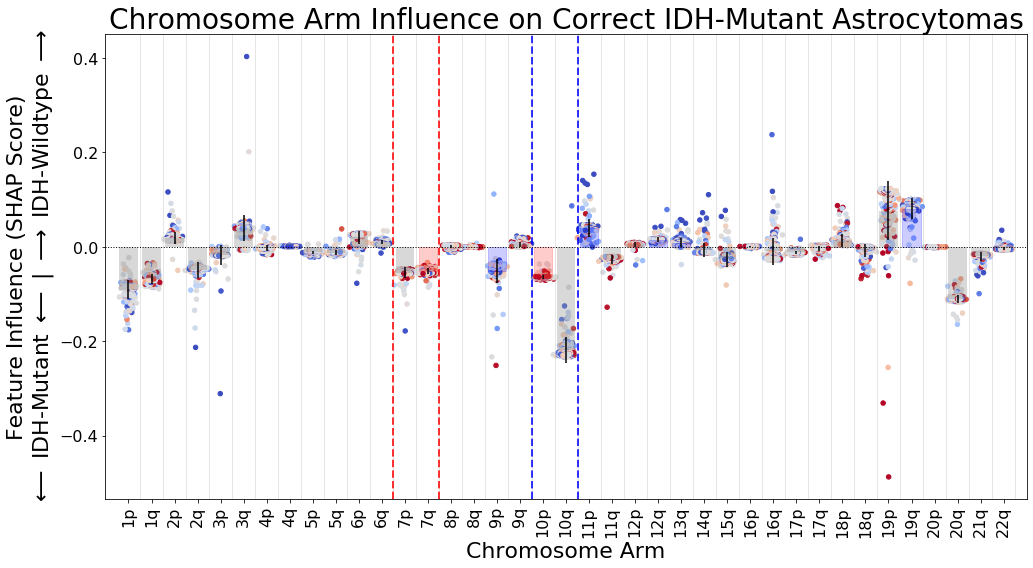

In [10]:
## Data for plot
# data
sample_epoch_stats_df_dict = copy.deepcopy(c_mut_sample_epoch_stats_df_dict)
_sample_data = train_chrarm_data_df.loc[sample_epoch_stats_df_dict.keys()]
# chrom arm order
chr_arm_order = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p', '5q', '6p', '6q', '7p', '7q', '8p', '8q', 
                 '9p', '9q', '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q', 
                 '18p', '18q', '19p', '19q',  '20p', '20q', '21q', '22q']

# find averages of SHAP values (per feature/chrom arm)
_running_mean_df = pd.DataFrame(index=chr_arm_order)
_running_std_df = pd.DataFrame(index=chr_arm_order)

for sample_idx in tqdm(sample_epoch_stats_df_dict.keys()):
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idx]['Mean']
    _epoch_mean_df = pd.DataFrame(data=_epoch_mean_df.values, index=_epoch_mean_df.index, columns=[sample_idx])
    _epoch_std_df = sample_epoch_stats_df_dict[sample_idx]['STD']
    _epoch_std_df = pd.DataFrame(data=_epoch_std_df.values, index=_epoch_std_df.index, columns=[sample_idx])
    
    _running_mean_df = pd.concat([_running_mean_df, _epoch_mean_df], axis=1, join='inner')
    _running_std_df = pd.concat([_running_std_df, _epoch_std_df], axis=1, join='inner')
    
running_mean_df = _running_mean_df.mean(axis=1)
running_std_df = _running_mean_df.std(axis=1)

# find average losses and gains to color in bars in bar chart with
_data_df = _sample_data[chr_arm_order].T.mean(axis=1)
loss1_idxs = _data_df.loc[(_data_df < -0.8)].index
loss2_idxs = _data_df.loc[(_data_df < -0.6) & (_data_df >= -0.8)].index
loss3_idxs = _data_df.loc[(_data_df < -0.4) & (_data_df >= -0.6)].index
loss4_idxs = _data_df.loc[(_data_df < -0.2) & (_data_df >= -0.4)].index
loss5_idxs = _data_df.loc[(_data_df < -0.1) & (_data_df >= -0.2)].index

gain1_idxs = _data_df.loc[(_data_df > 0.8)].index
gain2_idxs = _data_df.loc[(_data_df > 0.6) & (_data_df <= 0.8)].index
gain3_idxs = _data_df.loc[(_data_df > 0.4) & (_data_df <= 0.6)].index
gain4_idxs = _data_df.loc[(_data_df > 0.2) & (_data_df <= 0.4)].index
gain5_idxs = _data_df.loc[(_data_df > 0.1) & (_data_df <= 0.2)].index

mut_shap_df = pd.concat([running_mean_df, _data_df, running_std_df], axis=1).sort_values(0).rename(columns={0:'MUT_SHAP_Score',
                                                                                                  1:'MUT_Arm_avg',
                                                                                                  2:'MUT_STD'})

## SHAP Plot
fig, ax = plt.subplots(figsize=(15,8))

## Bar chart
# - running mean is the mean of all the shap values (dots) in the plot
_dict = {x:i/2+0.5 for i, x in enumerate(running_mean_df.reset_index()['index'])}
x_pos = running_mean_df.reset_index()['index'].replace(_dict)
barlist = plt.bar(x=x_pos, height=running_mean_df, yerr=running_std_df, width=0.4, facecolor="grey", alpha=0.3)


for i, chrarm in enumerate(chr_arm_order):
    if chrarm in loss1_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.6)
    elif chrarm in loss2_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.4)
    elif chrarm in loss3_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.3)
    elif chrarm in loss4_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.2)      
    elif chrarm in gain1_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.6)
    elif chrarm in gain2_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.4)
    elif chrarm in gain3_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.3)
    elif chrarm in gain4_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.2)

noise_dict = {}
for sample_idxs in sample_epoch_stats_df_dict.keys():
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idxs]
    _plot_df = pd.concat([_epoch_mean_df, _sample_data.T], axis=1, join='inner').reset_index()
    _plot_df['coor'] = _plot_df['index'].replace(_dict)
    _plot_df = _plot_df.iloc[::-1]
    _coors = _plot_df['coor'] + np.random.normal(0,0.075, len(_plot_df))
    plt.scatter(x=_coors, y=_plot_df['Mean'], c=_plot_df[sample_idxs], cmap="coolwarm", s=20, alpha=1) #vlag


## Draw Lines
for i in range(1, 22):
    plt.axvline(i-0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
    if i < 21:
        plt.axvline(i+0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
plt.axhline(0, color='black', linewidth=1, linestyle=':')

# 7 and 10 lines
plt.axvline(9.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(10.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(6.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(7.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)

## Plot labels / format
plt.title('Chromosome Arm Influence on Correct IDH-Mutant Astrocytomas', fontsize=28)

ylabel = 'Feature Influence (SHAP Score)\n'+r'$\longleftarrow$ IDH-Mutant $\longleftarrow$ | $\longrightarrow$ IDH-Wildtype $\longrightarrow$'
plt.ylabel(ylabel, fontsize=22)

plt.xlabel('Chromosome Arm', fontsize=22)
plt.xticks(_plot_df['coor'], _plot_df['index'], fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
plt.xlim(0, 20)
plt.tight_layout()

# Supplemental Figure 5

## Supplemental Figure 5A

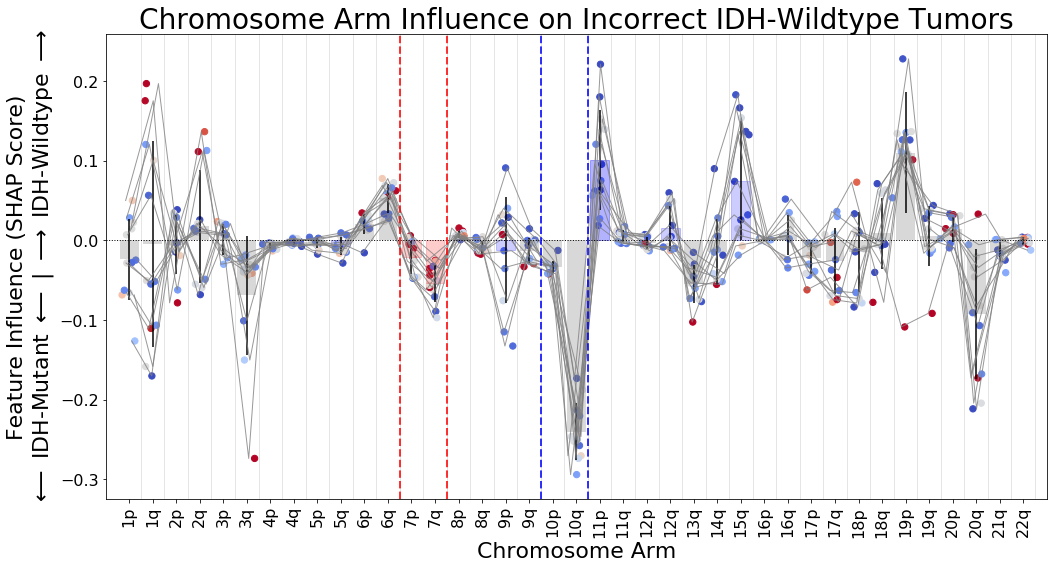

In [11]:
## Data for plot
# need "sample_epoch_stats_df_dict"
# data
sample_epoch_stats_df_dict = copy.deepcopy(w_wt_sample_epoch_stats_df_dict)
_sample_data = train_chrarm_data_df.loc[sample_epoch_stats_df_dict.keys()]
# chrom arm order
chr_arm_order = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p', '5q', '6p', '6q', '7p', '7q', '8p', '8q', 
                 '9p', '9q', '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q', 
                 '18p', '18q', '19p', '19q',  '20p', '20q', '21q', '22q']

# find averages of SHAP values (per feature/chrom arm)
_running_mean_df = pd.DataFrame(index=chr_arm_order)
_running_std_df = pd.DataFrame(index=chr_arm_order)

for sample_idx in tqdm(sample_epoch_stats_df_dict.keys()):
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idx]['Mean']
    _epoch_mean_df = pd.DataFrame(data=_epoch_mean_df.values, index=_epoch_mean_df.index, columns=[sample_idx])
    _epoch_std_df = sample_epoch_stats_df_dict[sample_idx]['STD']
    _epoch_std_df = pd.DataFrame(data=_epoch_std_df.values, index=_epoch_std_df.index, columns=[sample_idx])
    
    _running_mean_df = pd.concat([_running_mean_df, _epoch_mean_df], axis=1, join='inner')
    _running_std_df = pd.concat([_running_std_df, _epoch_std_df], axis=1, join='inner')
    
running_mean_df = _running_mean_df.mean(axis=1)
running_std_df = _running_mean_df.std(axis=1)

# find average losses and gains to color in bars in bar chart with
_data_df = _sample_data[chr_arm_order].T.mean(axis=1)
loss1_idxs = _data_df.loc[(_data_df < -0.8)].index
loss2_idxs = _data_df.loc[(_data_df < -0.6) & (_data_df >= -0.8)].index
loss3_idxs = _data_df.loc[(_data_df < -0.4) & (_data_df >= -0.6)].index
loss4_idxs = _data_df.loc[(_data_df < -0.2) & (_data_df >= -0.4)].index
loss5_idxs = _data_df.loc[(_data_df < -0.1) & (_data_df >= -0.2)].index

gain1_idxs = _data_df.loc[(_data_df > 0.8)].index
gain2_idxs = _data_df.loc[(_data_df > 0.6) & (_data_df <= 0.8)].index
gain3_idxs = _data_df.loc[(_data_df > 0.4) & (_data_df <= 0.6)].index
gain4_idxs = _data_df.loc[(_data_df > 0.2) & (_data_df <= 0.4)].index
gain5_idxs = _data_df.loc[(_data_df > 0.1) & (_data_df <= 0.2)].index

w_wt_shap_df = pd.concat([running_mean_df, _data_df, running_std_df], axis=1).sort_values(0).rename(columns={0:'w_WT_SHAP_Score',
                                                                                                  1:'w_WT_Arm_avg',
                                                                                                  2:'w_WT_STD'})

## SHAP Plot
fig, ax = plt.subplots(figsize=(15,8))

## Bar chart
# - running mean is the mean of all the shap values (dots) in the plot
_dict = {x:i/2+0.5 for i, x in enumerate(running_mean_df.reset_index()['index'])}
x_pos = running_mean_df.reset_index()['index'].replace(_dict)
barlist = plt.bar(x=x_pos, height=running_mean_df, yerr=running_std_df, width=0.4, facecolor="grey", alpha=0.3)


for i, chrarm in enumerate(chr_arm_order):
    if chrarm in loss1_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.6)
    elif chrarm in loss2_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.4)
    elif chrarm in loss3_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.3)
    elif chrarm in loss4_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.2)
#     elif chrarm in loss5_idxs:
#         barlist[i].set_color('blue')
#         barlist[i].set_alpha(0.1)
        
    elif chrarm in gain1_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.6)
    elif chrarm in gain2_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.4)
    elif chrarm in gain3_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.3)
    elif chrarm in gain4_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.2)
#     elif chrarm in gain5_idxs:
#         barlist[i].set_color('red')
#         barlist[i].set_alpha(0.1)

noise_dict = {}
## Scatter plot
for sample_idxs in sample_epoch_stats_df_dict.keys():
#     noise_dict[sample_idxs] = np.random.normal(0,0.075, len(_plot_df))
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idxs]
    _plot_df = pd.concat([_epoch_mean_df, _sample_data.T], axis=1, join='inner').reset_index()
    _plot_df['coor'] = _plot_df['index'].replace(_dict)
    _plot_df = _plot_df.iloc[::-1]
    _coors = _plot_df['coor'] + np.random.normal(0,0.075, len(_plot_df))
#     plt.scatter(x=_coors, y=_plot_df['Mean'], c=_plot_df[sample_idxs], cmap="coolwarm", s=40, alpha=0.8) #vlag
    plt.plot(_coors, _plot_df['Mean'], c='grey', linewidth=1, alpha=0.8) #vlag
#     plt.plot(_coors, _plot_df['Mean']) #vlag
for sample_idxs in sample_epoch_stats_df_dict.keys():
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idxs]
    _plot_df = pd.concat([_epoch_mean_df, _sample_data.T], axis=1, join='inner').reset_index()
    _plot_df['coor'] = _plot_df['index'].replace(_dict)
    _plot_df = _plot_df.iloc[::-1]
    _coors = _plot_df['coor'] + np.random.normal(0,0.075, len(_plot_df))
    plt.scatter(x=_coors, y=_plot_df['Mean'], c=_plot_df[sample_idxs], cmap="coolwarm", s=40, alpha=1) #vlag
#     plt.plot(_coors, _plot_df['Mean'], c='grey', linewidth=1, alpha=0.8) #vlag


## Draw Lines
for i in range(1, 22):
    plt.axvline(i-0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
    if i < 21:
        plt.axvline(i+0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
plt.axhline(0, color='black', linewidth=1, linestyle=':')

# 7 and 10 lines
plt.axvline(9.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(10.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(6.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(7.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)

## Plot labels / format
plt.title('Chromosome Arm Influence on Incorrect IDH-Wildtype Tumors', fontsize=28)
ylabel = 'Feature Influence (SHAP Score)\n'+r'$\longleftarrow$ IDH-Mutant $\longleftarrow$ | $\longrightarrow$ IDH-Wildtype $\longrightarrow$'
plt.ylabel(ylabel, fontsize=22)
plt.xlabel('Chromosome Arm', fontsize=22)
plt.xticks(_plot_df['coor'], _plot_df['index'], fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
# plt.ylim(-0.25, 0.25)
plt.xlim(0, 20)
plt.tight_layout()

## Supplemental Figure 5B

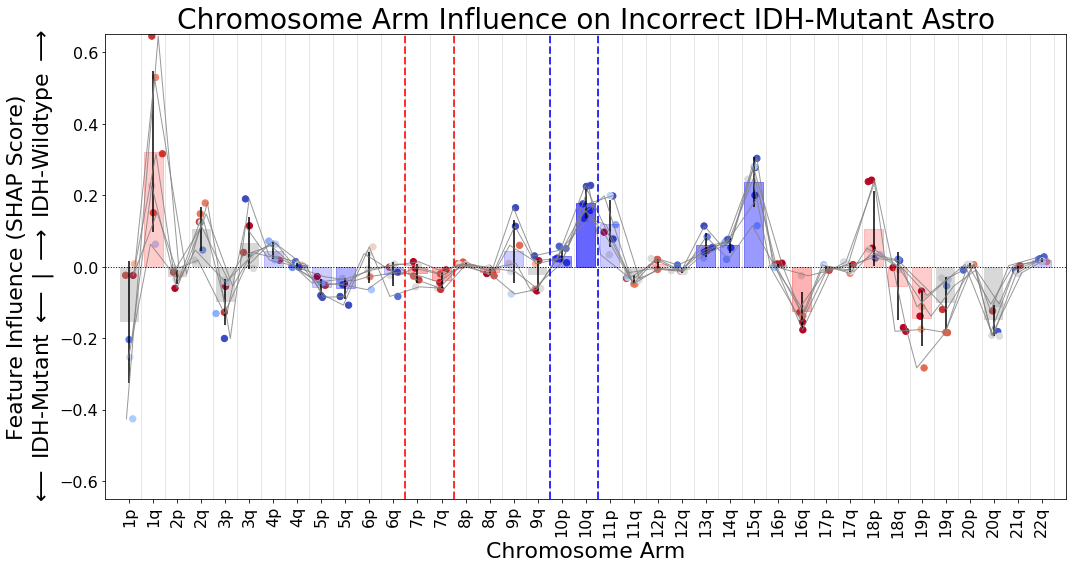

In [12]:
## Data for plot
# need "sample_epoch_stats_df_dict"
# data
sample_epoch_stats_df_dict = copy.deepcopy(w_mut_sample_epoch_stats_df_dict)
_sample_data = train_chrarm_data_df.loc[sample_epoch_stats_df_dict.keys()]
# chrom arm order
chr_arm_order = ['1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p', '5q', '6p', '6q', '7p', '7q', '8p', '8q', 
                 '9p', '9q', '10p', '10q', '11p', '11q', '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q', 
                 '18p', '18q', '19p', '19q',  '20p', '20q', '21q', '22q']

# find averages of SHAP values (per feature/chrom arm)
_running_mean_df = pd.DataFrame(index=chr_arm_order)
_running_std_df = pd.DataFrame(index=chr_arm_order)

for sample_idx in tqdm(sample_epoch_stats_df_dict.keys()):
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idx]['Mean']
    _epoch_mean_df = pd.DataFrame(data=_epoch_mean_df.values, index=_epoch_mean_df.index, columns=[sample_idx])
    _epoch_std_df = sample_epoch_stats_df_dict[sample_idx]['STD']
    _epoch_std_df = pd.DataFrame(data=_epoch_std_df.values, index=_epoch_std_df.index, columns=[sample_idx])
    
    _running_mean_df = pd.concat([_running_mean_df, _epoch_mean_df], axis=1, join='inner')
    _running_std_df = pd.concat([_running_std_df, _epoch_std_df], axis=1, join='inner')
    
running_mean_df = _running_mean_df.mean(axis=1)
running_std_df = _running_mean_df.std(axis=1)

# find average losses and gains to color in bars in bar chart with
_data_df = _sample_data[chr_arm_order].T.mean(axis=1)
loss1_idxs = _data_df.loc[(_data_df < -0.8)].index
loss2_idxs = _data_df.loc[(_data_df < -0.6) & (_data_df >= -0.8)].index
loss3_idxs = _data_df.loc[(_data_df < -0.4) & (_data_df >= -0.6)].index
loss4_idxs = _data_df.loc[(_data_df < -0.2) & (_data_df >= -0.4)].index
loss5_idxs = _data_df.loc[(_data_df < -0.1) & (_data_df >= -0.2)].index

gain1_idxs = _data_df.loc[(_data_df > 0.8)].index
gain2_idxs = _data_df.loc[(_data_df > 0.6) & (_data_df <= 0.8)].index
gain3_idxs = _data_df.loc[(_data_df > 0.4) & (_data_df <= 0.6)].index
gain4_idxs = _data_df.loc[(_data_df > 0.2) & (_data_df <= 0.4)].index
gain5_idxs = _data_df.loc[(_data_df > 0.1) & (_data_df <= 0.2)].index

w_mut_shap_df = pd.concat([running_mean_df, _data_df, running_std_df], axis=1).sort_values(0).rename(columns={0:'w_MUT_SHAP_Score',
                                                                                                  1:'w_MUT_Arm_avg',
                                                                                                  2:'w_MUT_STD'})

## SHAP Plot
fig, ax = plt.subplots(figsize=(15,8))

## Bar chart
# - running mean is the mean of all the shap values (dots) in the plot
_dict = {x:i/2+0.5 for i, x in enumerate(running_mean_df.reset_index()['index'])}
x_pos = running_mean_df.reset_index()['index'].replace(_dict)
barlist = plt.bar(x=x_pos, height=running_mean_df, yerr=running_std_df, width=0.4, facecolor="grey", alpha=0.3)


for i, chrarm in enumerate(chr_arm_order):
    if chrarm in loss1_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.6)
    elif chrarm in loss2_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.4)
    elif chrarm in loss3_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.3)
    elif chrarm in loss4_idxs:
        barlist[i].set_color('blue')
        barlist[i].set_alpha(0.2)
#     elif chrarm in loss5_idxs:
#         barlist[i].set_color('blue')
#         barlist[i].set_alpha(0.1)
        
    elif chrarm in gain1_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.6)
    elif chrarm in gain2_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.4)
    elif chrarm in gain3_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.3)
    elif chrarm in gain4_idxs:
        barlist[i].set_color('red')
        barlist[i].set_alpha(0.2)
#     elif chrarm in gain5_idxs:
#         barlist[i].set_color('red')
#         barlist[i].set_alpha(0.1)

noise_dict = {}
## Scatter plot
for sample_idxs in sample_epoch_stats_df_dict.keys():
#     noise_dict[sample_idxs] = 
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idxs]
    _plot_df = pd.concat([_epoch_mean_df, _sample_data.T], axis=1, join='inner').reset_index()
    _plot_df['coor'] = _plot_df['index'].replace(_dict)
    _plot_df = _plot_df.iloc[::-1]
    _coors = _plot_df['coor'] + np.random.normal(0,0.075, len(_plot_df))
#     plt.scatter(x=_coors, y=_plot_df['Mean'], c=_plot_df[sample_idxs], cmap="coolwarm", s=40, alpha=0.8) #vlag
    plt.plot(_coors, _plot_df['Mean'], c='grey', linewidth=1, alpha=0.8) #vlag
#     plt.plot(_coors, _plot_df['Mean']) #vlag
for sample_idxs in sample_epoch_stats_df_dict.keys():
    _epoch_mean_df = sample_epoch_stats_df_dict[sample_idxs]
    _plot_df = pd.concat([_epoch_mean_df, _sample_data.T], axis=1, join='inner').reset_index()
    _plot_df['coor'] = _plot_df['index'].replace(_dict)
    _plot_df = _plot_df.iloc[::-1]
    _coors = _plot_df['coor'] + np.random.normal(0,0.075, len(_plot_df))
    plt.scatter(x=_coors, y=_plot_df['Mean'], c=_plot_df[sample_idxs], cmap="coolwarm", s=40, alpha=1) #vlag
#     plt.plot(_coors, _plot_df['Mean'], c='grey', linewidth=1, alpha=0.8) #vlag


## Draw Lines
for i in range(1, 22):
    plt.axvline(i-0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
    if i < 21:
        plt.axvline(i+0.25, color='grey', linewidth=1, linestyle='-', alpha=0.2)
plt.axhline(0, color='black', linewidth=1, linestyle=':')

# 7 and 10 lines
plt.axvline(9.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(10.5-0.25, color='blue', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(6.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)
plt.axvline(7.5-0.25, color='red', linewidth=2, linestyle='--', alpha=0.8)

## Plot labels / format
plt.title('Chromosome Arm Influence on Incorrect IDH-Mutant Astro', fontsize=28)
ylabel = 'Feature Influence (SHAP Score)\n'+r'$\longleftarrow$ IDH-Mutant $\longleftarrow$ | $\longrightarrow$ IDH-Wildtype $\longrightarrow$'
plt.ylabel(ylabel, fontsize=22)
plt.xlabel('Chromosome Arm', fontsize=22)
plt.xticks(_plot_df['coor'], _plot_df['index'], fontsize=16, rotation = 90)
plt.yticks(fontsize=16)
plt.ylim(-0.65, 0.65)
plt.xlim(0, 20)
plt.tight_layout()

# Figure 4E

In [13]:
_df = pd.concat([wt_shap_df, mut_shap_df, w_wt_shap_df, w_mut_shap_df], axis=1)
_df['SHAP_Score'] = _df[['WT_SHAP_Score', 'MUT_SHAP_Score']].abs().mean(axis=1)
_df = _df.sort_values('SHAP_Score', ascending=False).drop(columns=['WT_STD', 'MUT_STD'])

plot_df = _df.reset_index().rename(columns={'index':'group'})#, 'MUT_Arm_avg':'value1', 'WT_Arm_avg':'value2'})
plot_df = plot_df.loc[plot_df['SHAP_Score'] > 0.03].sort_values('SHAP_Score')

_shap_values = plot_df['WT_SHAP_Score'].append(plot_df['MUT_SHAP_Score']).reset_index()[0].abs()
_shap_values.abs().min(), _shap_values.abs().mean(), _shap_values.abs().max()

/home/nknuecht/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(0.024329621997049924, 0.07289975272770124, 0.21877571143499555)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


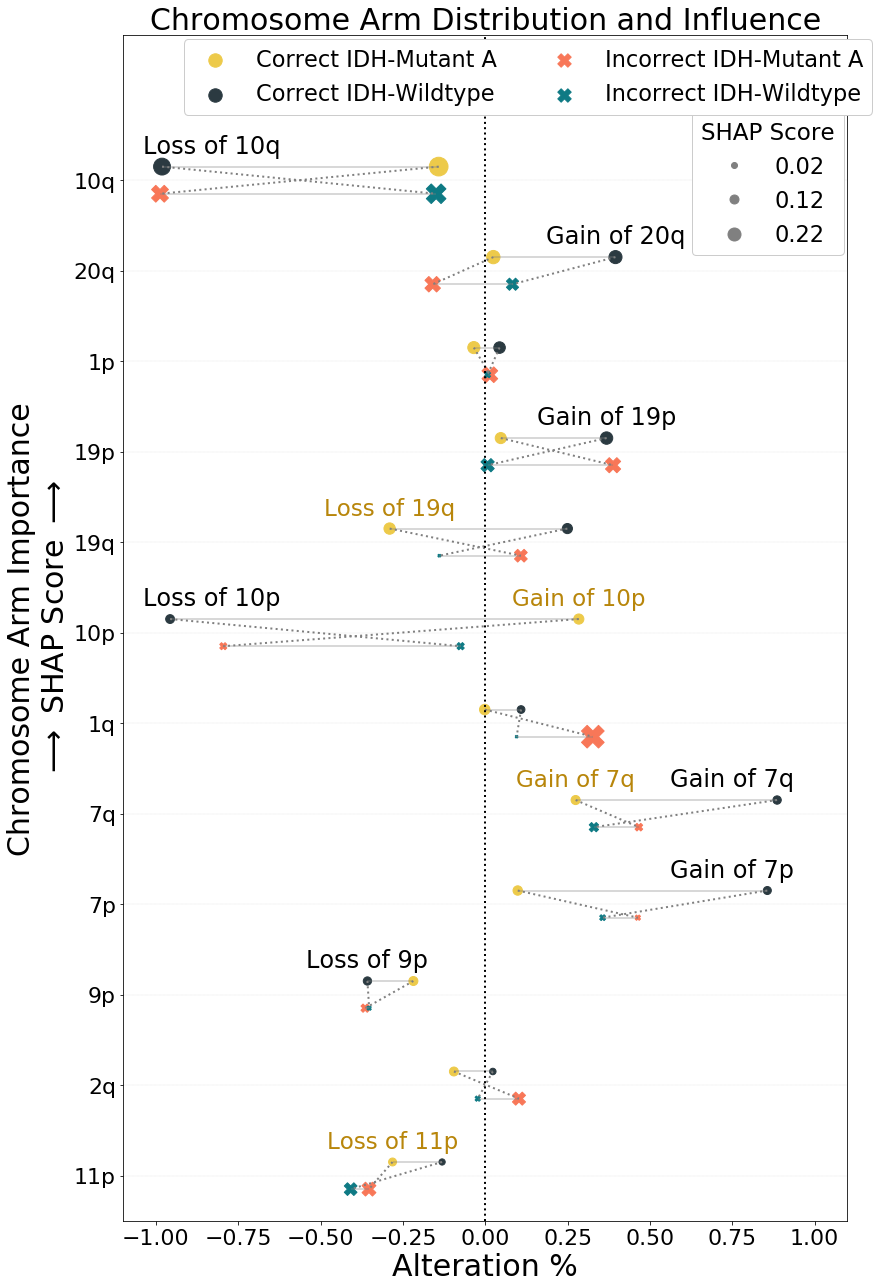

In [14]:
color_dict = {'c_wt':'#2b3a41', 'w_wt':'#0e7a84', 'w_mut':'#f87758', 'c_mut':'#edca4a'}

 
ax, fig = plt.subplots(figsize=(12,18))
my_range=range(1,len(plot_df.index)+1)
c_range = [x + 0.15 for x in my_range]

w_range = [x - 0.15 for x in my_range]
plt.hlines(y=c_range, xmin=plot_df['MUT_Arm_avg'], xmax=plot_df['WT_Arm_avg'], color='grey', alpha=0.4)
plt.hlines(y=w_range, xmin=plot_df['w_MUT_Arm_avg'], xmax=plot_df['w_WT_Arm_avg'], color='grey', alpha=0.4)

c_mut_label = 'Correct IDH-Mutant A'
c_wt_label = 'Correct IDH-Wildtype'
w_mut_label = 'Incorrect IDH-Mutant A'
w_wt_label = 'Incorrect IDH-Wildtype'

dotsize = 1600
plt.scatter(plot_df['MUT_Arm_avg'], c_range, color=color_dict['c_mut'], alpha=1, label= c_mut_label, 
            s=plot_df['MUT_SHAP_Score'].abs()*dotsize)
plt.scatter(plot_df['WT_Arm_avg'], c_range, color=color_dict['c_wt'], alpha=1 , label=c_wt_label, 
            s=plot_df['WT_SHAP_Score'].abs()*dotsize)

plt.scatter(plot_df['w_MUT_Arm_avg'], w_range, color=color_dict['w_mut'], alpha=1, label=w_mut_label, 
            s=plot_df['w_MUT_SHAP_Score'].abs()*dotsize, marker='X')
plt.scatter(plot_df['w_WT_Arm_avg'], w_range, color=color_dict['w_wt'], alpha=1 , label=w_wt_label, 
            s=plot_df['w_WT_SHAP_Score'].abs()*dotsize, marker='X')

## draw lines between wrong and right predictions of the same subtype
for i in my_range:
    y, w_y = i + 0.15, i - 0.15
    # wildtypes
    x, w_x = plot_df[['WT_Arm_avg', 'w_WT_Arm_avg']].iloc[i-1].values
    plt.plot([x, w_x], [y, w_y], color='gray', linestyle=':', linewidth=2)
    
    # mutants
    x, w_x = plot_df[['MUT_Arm_avg', 'w_MUT_Arm_avg']].iloc[i-1].values
    plt.plot([x, w_x], [y, w_y], color='gray', linestyle=':', linewidth=2)

###### Legend 1 ########
legend = plt.legend(fontsize=22.5, bbox_to_anchor=(0.559, 0.965), loc='center', framealpha=1, ncol=2)
plt.setp(legend.get_title(),fontsize=23)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [180]
###########################

## Add title and axis names
plt.yticks(my_range, plot_df['group'])
plt.title('Chromosome Arm Distribution and Influence', fontsize=30)
ylabel = 'Chromosome Arm Importance\n'+r'$\longrightarrow$ SHAP Score $\longrightarrow$'

plt.ylabel(ylabel, fontsize=30)
plt.xlabel('Alteration %', fontsize=30)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.axvline(x=0, linestyle=':', linewidth=2, color='k')

for i in range(len(plot_df)):
    plt.axhline(y=i+1, linestyle=':', linewidth=0.1, color='k')

for idx in plot_df.index:
    _idx = 12 - idx
    chrarm = plot_df.loc[idx]['group']
    
    wt_xpos = plot_df.loc[idx]['WT_Arm_avg']
    alt = None
    if wt_xpos > 0.25:
        alt = 'Gain'
        wt_xpos = np.min([wt_xpos, 0.75])
    elif wt_xpos < -0.25:
        alt = 'Loss'
        wt_xpos = np.max([wt_xpos, -0.83])
    
    if alt:
        text = alt + ' of ' + chrarm
        plt.text(x = wt_xpos, y=_idx+0.3, s=text, color='k', fontsize=24, horizontalalignment='center')
        
    mut_xpos = plot_df.loc[idx]['MUT_Arm_avg']
    alt = None
    if mut_xpos > 0.25:
        alt = 'Gain'
        mut_xpos = np.min([mut_xpos, 0.8])
    elif mut_xpos < -0.25:
        alt = 'Loss'
        mut_xpos = np.max([mut_xpos, -0.9])
    
    if alt:
        text = alt + ' of ' + chrarm
        plt.text(x = mut_xpos, y=_idx+0.3, s=text, color='darkgoldenrod', fontsize=23, horizontalalignment='center')

######## Legend 2 ##########
ax.add_artist(legend)
_range = [np.round(x,2) for x in np.linspace(_shap_values.abs().min(), _shap_values.abs().max(), 3)]
size_legend_sizes = [6,9,13]

h = [plt.plot([],[], color="gray", marker="o", ms=i, ls="")[0] for i in size_legend_sizes]
leg = plt.legend(handles=h, labels=_range,bbox_to_anchor=(0.89, 0.875), title="SHAP Score", 
                 fontsize=22.5, framealpha=1, loc='center')
plt.setp(leg.get_title(),fontsize=23)
############################
plt.ylim(0.5, 13.6)
plt.xlim(-1.1, 1.1)

plt.tight_layout()

# Supplemental Figures

## Sup Figure 4A

In [15]:
# Somatic copy number alteration (SCNA) data
!wget -P ../data/ https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz

--2021-12-30 10:26:11--  https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz
Resolving tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)... 52.217.89.128
Connecting to tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)|52.217.89.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1804219 (1.7M) [binary/octet-stream]
Saving to: ‘../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz.4’

TCGA.GBMLGG.sampleM 100%[===================>]   1.72M   742KB/s    in 2.4s    

2021-12-30 10:26:14 (742 KB/s) - ‘../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz.4’ saved [1804219/1804219]



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


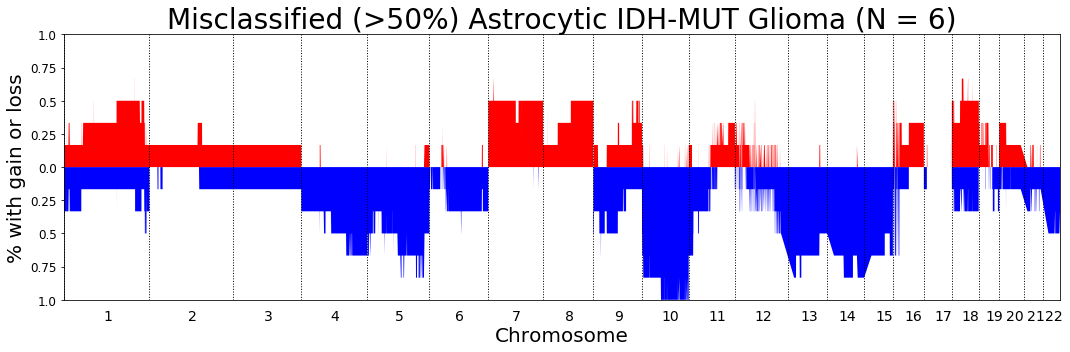

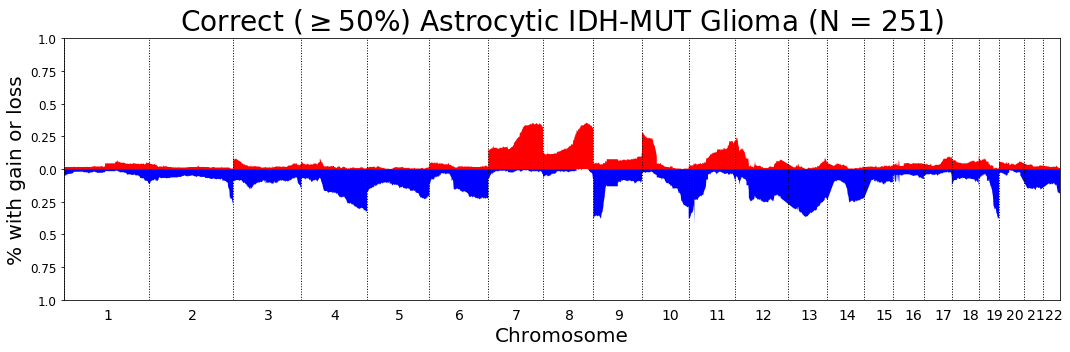

In [16]:
figsize = (15,5)
# using UCSC hg19 data for data size convenience 
scna_filepath = '../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz'
manhattan_scna_df = pd.read_csv(scna_filepath, sep='\t', index_col=0).T
manhattan_scna_df.index = manhattan_scna_df.index.str[:-3]
manhattan_gene_loc_df = pd.read_csv('../data/gene_data/manhattan_gene_loc.csv', index_col=0)

# misclassified MUTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                             & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
save, outfile = False, None

title = 'Misclassified (>50%) Astrocytic IDH-MUT Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)


# misclassified MUTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                             & (cv_predictions_df['Avg Misclassified'] <= 0.5)].index
save, outfile = False, None

title = r'Correct ($\geq$50%) Astrocytic IDH-MUT Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)


## Sup Figure 4B

get predictions . . . 
correct_mut_idxs: 251
incorrect_mut_idxs: 6
plot 1 . . . .
240 1 11 5
fisher exact = 2.8109646228078696e-06


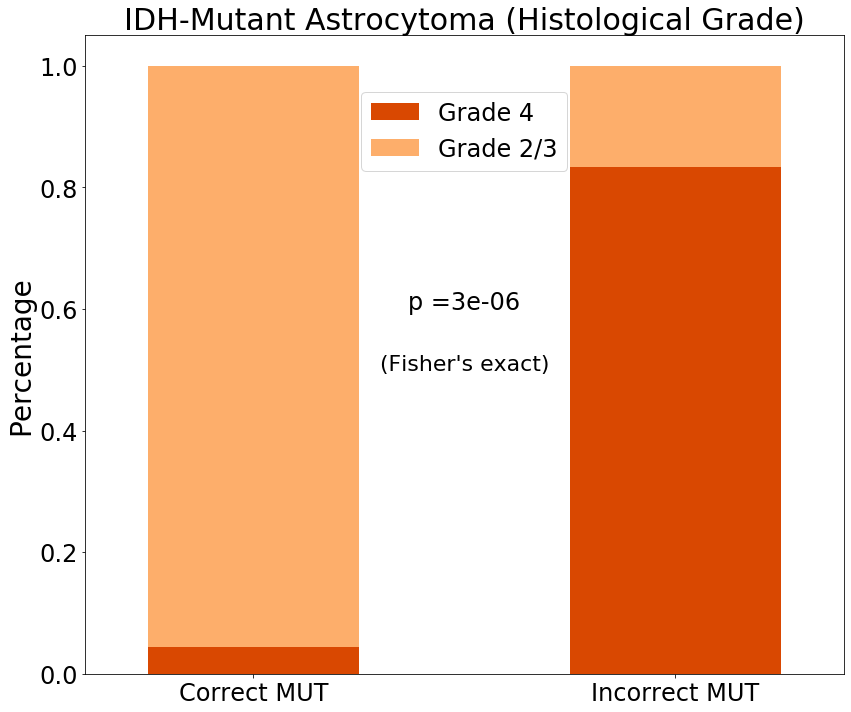

In [17]:
print('get predictions . . . ')
error_thresh = 0.5
correct_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
print('correct_mut_idxs:', len(correct_mut_idxs))

incorrect_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
print('incorrect_mut_idxs:', len(incorrect_mut_idxs))

## plot histological grade distribution ##
print('plot 1 . . . .')
# wildtypes
## Build DataFrame ####
lgg_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] != 'G4'].index
g4_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] == 'G4'].index

lgg_correct_mut_idxs = [x for x in correct_mut_idxs if x in lgg_idxs]
lgg_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in lgg_idxs]
g4_correct_mut_idxs = [x for x in correct_mut_idxs if x in g4_idxs]
g4_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in g4_idxs]

print(len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs), len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs))

# data
data_df = pd.DataFrame(data=[[len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs)],
                             [len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs)], ], 
                       index=['Grade 4', 'Grade 2/3'],
                       columns=[u'Correct MUT', u'Incorrect MUT'])

## Plot ##
save = False
df_temp = (data_df/data_df.sum(axis=0)).T

df_temp.plot.bar(stacked=True, figsize=(12, 10), color=['#d94801', '#fdae6b'])
plt.title('IDH-Mutant Astrocytoma (Histological Grade)', fontsize=30)
plt.xticks(rotation=0, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Percentage', fontsize=28)
plt.legend(fontsize=24, bbox_to_anchor=(0.5,0.85), loc="center")
plt.xlim(-0.4,1.4)

## fisher's exact test
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(data_df.values)
print('fisher exact =', pvalue)
plt.text(x = 0.5, y=0.6, s='p ='+str(np.round(pvalue, 6)), color='black', fontsize=24, horizontalalignment='center')
plt.text(x = 0.5, y=0.5, s="(Fisher's exact)", color='black', fontsize=22, horizontalalignment='center')
##

plt.tight_layout()

218 1 33 5
fisher exact = 0.0002986306165531805


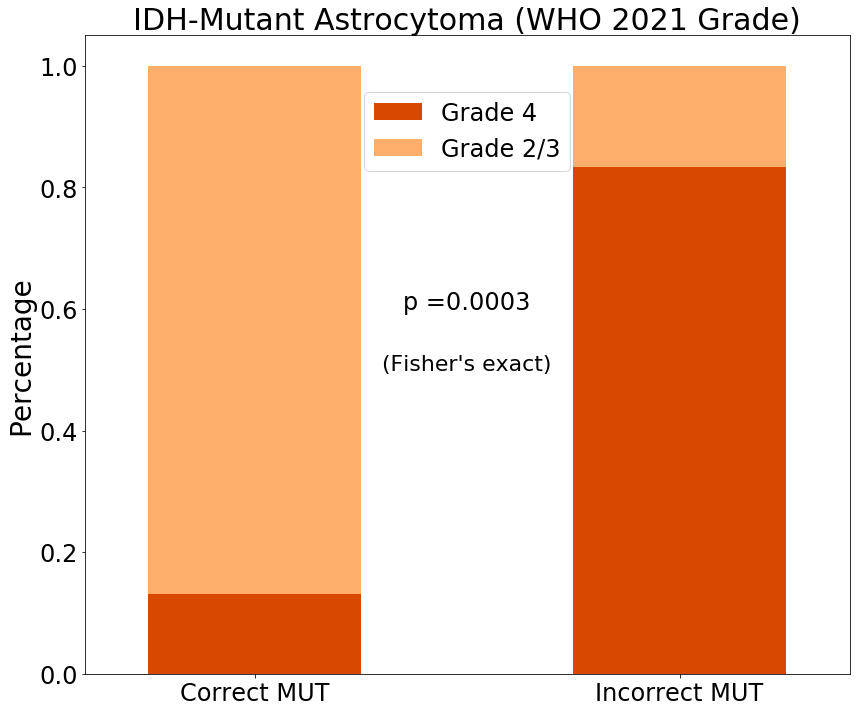

In [18]:
lgg_idxs = tcga_clinical_df.loc[tcga_clinical_df['WHO_2021_Grade'] != 'G4'].index
g4_idxs = tcga_clinical_df.loc[tcga_clinical_df['WHO_2021_Grade'] == 'G4'].index

lgg_correct_mut_idxs = [x for x in correct_mut_idxs if x in lgg_idxs]
lgg_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in lgg_idxs]
g4_correct_mut_idxs = [x for x in correct_mut_idxs if x in g4_idxs]
g4_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in g4_idxs]

print(len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs), len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs))

# data
data_df = pd.DataFrame(data=[[len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs)],
                             [len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs)]], 
                       index=['Grade 4', 'Grade 2/3'],
                       columns=[u'Correct MUT', u'Incorrect MUT'])

## Plot ##
save = False
df_temp = (data_df/data_df.sum(axis=0)).T
df_temp.plot.bar(stacked=True, figsize=(12, 10), color=['#d94801', '#fdae6b'])
plt.title('IDH-Mutant Astrocytoma (WHO 2021 Grade)', fontsize=30)
plt.xticks(rotation=0, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Percentage', fontsize=28)
plt.legend(fontsize=24, bbox_to_anchor=(0.5,0.85), loc="center")
plt.xlim(-0.4,1.4)

## fisher's exact test
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(data_df.values)
print('fisher exact =', pvalue)
plt.text(x = 0.5, y=0.6, s='p ='+str(np.round(pvalue, 5)), color='black', fontsize=24, horizontalalignment='center')
plt.text(x = 0.5, y=0.5, s="(Fisher's exact)", color='black', fontsize=22, horizontalalignment='center')
##

plt.tight_layout()

## Sup Figure 4C

/home/nknuecht/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:652: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/home/nknuecht/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:652: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


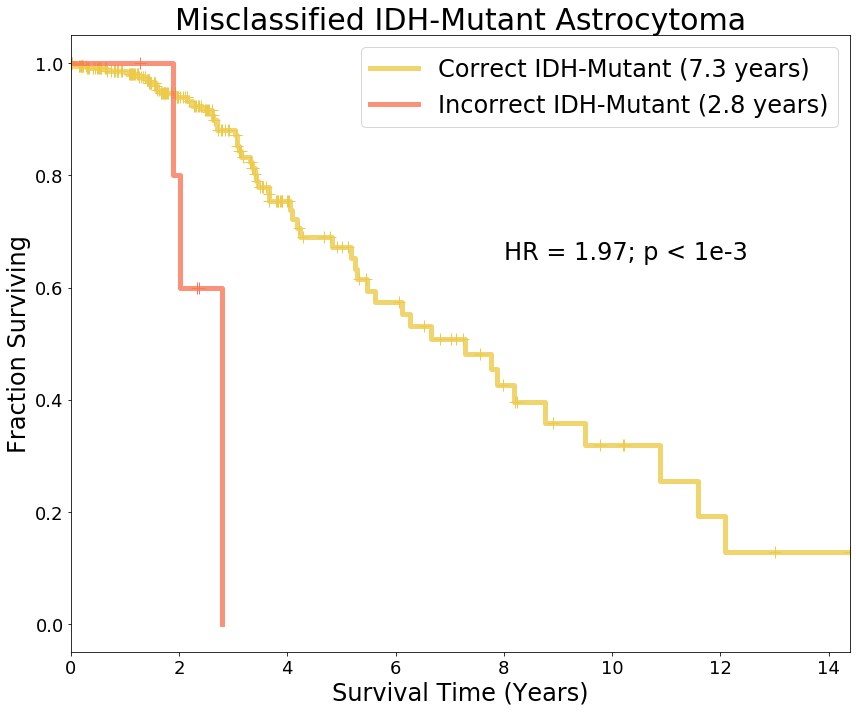

,p-value
"('Correct IDH-Mutant', 'Incorrect IDH-Mutant')",0.000258


In [19]:
save = False; outfile = None

error_thresh = 0.5
correct_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index.tolist()
incorrect_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index.tolist()

idxs = correct_mut_idxs + incorrect_mut_idxs
label_df = pd.DataFrame(index=idxs, columns=['label'])
label_df.loc[correct_mut_idxs, 'label'] = 'Correct IDH-Mutant'
label_df.loc[incorrect_mut_idxs, 'label'] = 'Incorrect IDH-Mutant'
exclude_labels = []

temp_style_dict = {}
temp_style_dict['Correct IDH-Mutant'] = {'color': color_dict['c_mut'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}
temp_style_dict['Incorrect IDH-Mutant'] = {'color': color_dict['w_mut'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}

title = 'Misclassified IDH-Mutant Astrocytoma'
kmf_df = pd.concat([tcga_clinical_df[['OS', 'OS_EVENT']], label_df], axis=1, join='inner')

save = False
result_df = survival_curves(kmf_df, 
                            title=title, 
                            save=save, 
                            outfile=outfile, 
                            show_p_value=True,
                            text_xpos=8, 
                            p_size=24,
                            text_ypos=0.65,
                            ci_show=False,
                            legend_size=24,
                            show_longtail=False,
                            exclude_labels=exclude_labels,
                            p_longtail=0.2,
                            pval_dec=3,
                            style_dict=temp_style_dict,
                            figsize=(12,10),
                            hr_replace_dict={'Correct IDH-Mutant':0, 'Incorrect IDH-Mutant':1},
                            titlesize=30,
                            show_hr=True)
get_pairwise_p_values(result_df['kmf'])

## Sup Figure 4D

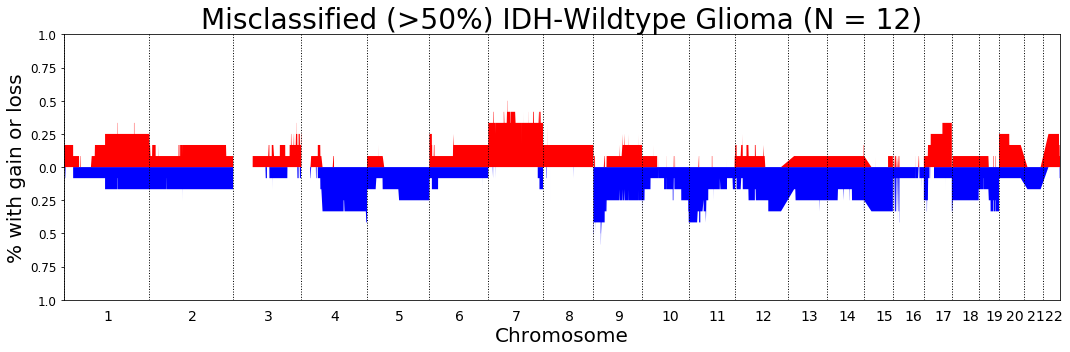

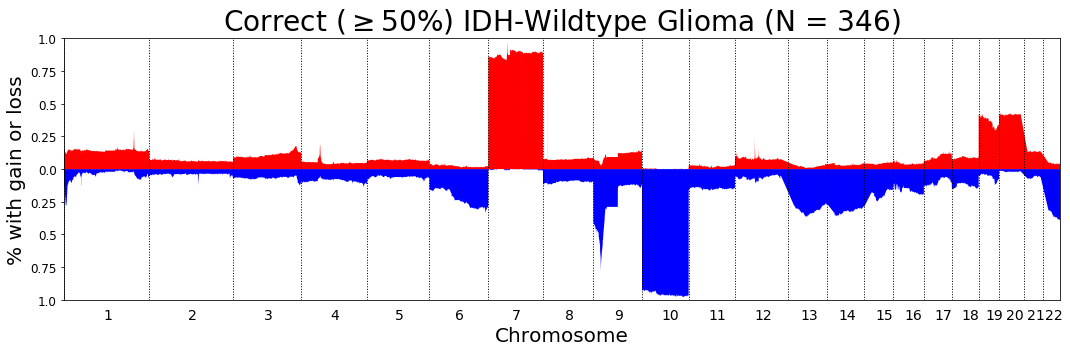

In [20]:
figsize = (15,5)
# using UCSC hg19 data for data size convenience 
scna_filepath = '../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz'
manhattan_scna_df = pd.read_csv(scna_filepath, sep='\t', index_col=0).T
manhattan_scna_df.index = manhattan_scna_df.index.str[:-3]
manhattan_gene_loc_df = pd.read_csv('../data/gene_data/manhattan_gene_loc.csv', index_col=0)

# misclassified WTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                             & (cv_predictions_df['Avg Misclassified'] > 0.5)].index

title = 'Misclassified (>50%) IDH-Wildtype Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

save, outfile = False, None
plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)


# correct WTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                             & (cv_predictions_df['Avg Misclassified'] <= 0.5)].index

title = r'Correct ($\geq$50%) IDH-Wildtype Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

save, outfile = False, None
plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)

## Sup Figure 4E

correct_wt_idxs: 346
incorrect_wt_idxs: 12
68 2 278 10
fisher exact = 1.0


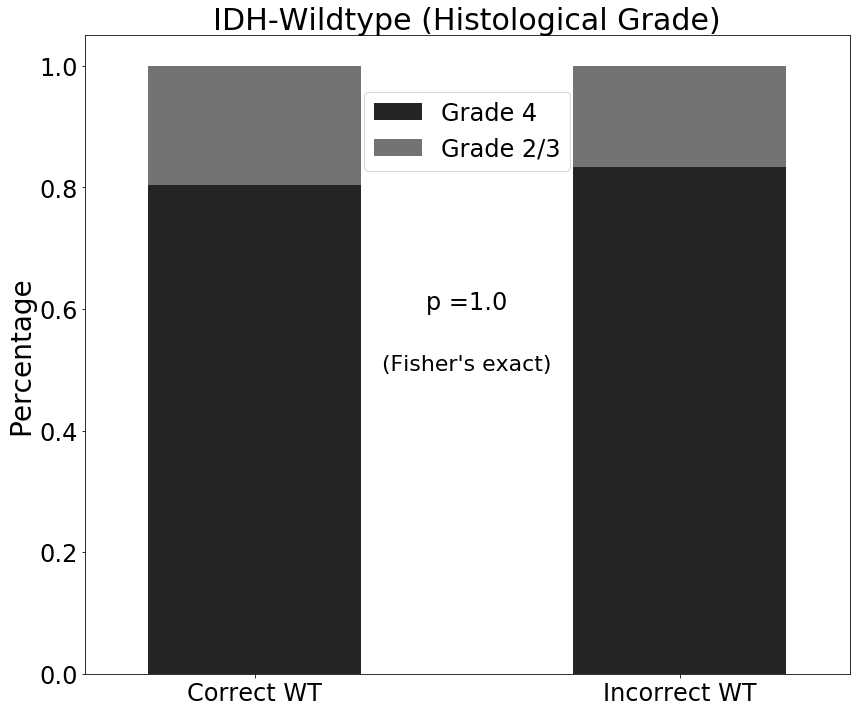

In [21]:
error_thresh = 0.5
correct_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
print('correct_wt_idxs:', len(correct_wt_idxs))

incorrect_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
print('incorrect_wt_idxs:', len(incorrect_wt_idxs))

# wildtypes
## Build DataFrame ####
lgg_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] != 'G4'].index
g4_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] == 'G4'].index

lgg_correct_wt_idxs = [x for x in correct_wt_idxs if x in lgg_idxs]
lgg_incorrect_wt_idxs = [x for x in incorrect_wt_idxs if x in lgg_idxs]
g4_correct_wt_idxs = [x for x in correct_wt_idxs if x in g4_idxs]
g4_incorrect_wt_idxs = [x for x in incorrect_wt_idxs if x in g4_idxs]

print(len(lgg_correct_wt_idxs), len(lgg_incorrect_wt_idxs), len(g4_correct_wt_idxs), len(g4_incorrect_wt_idxs))

# data
data_df = pd.DataFrame(data=[[len(g4_correct_wt_idxs), len(g4_incorrect_wt_idxs)],
                             [len(lgg_correct_wt_idxs), len(lgg_incorrect_wt_idxs)]
                            ], 
                       index=['Grade 4', 'Grade 2/3'],
                       columns=[u'Correct WT', u'Incorrect WT'])
## Plot ##
save = False
df_temp = (data_df/data_df.sum(axis=0)).T
df_temp.plot.bar(stacked=True, figsize=(12, 10), color=['#252525', '#737373'])
plt.title('IDH-Wildtype (Histological Grade)', fontsize=30)
plt.xticks(rotation=0, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Percentage', fontsize=28)
plt.legend(fontsize=24, bbox_to_anchor=(0.5,0.85), loc="center")
plt.xlim(-0.4,1.4)

## fisher's exact test
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(data_df.values)
print('fisher exact =', pvalue)
plt.text(x = 0.5, y=0.6, s='p ='+str(np.round(pvalue, 5)), color='black', fontsize=24, horizontalalignment='center')
plt.text(x = 0.5, y=0.5, s="(Fisher's exact)", color='black', fontsize=22, horizontalalignment='center')
##

plt.tight_layout()

## Sup Figure 4F

/home/nknuecht/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:652: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
/home/nknuecht/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:652: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


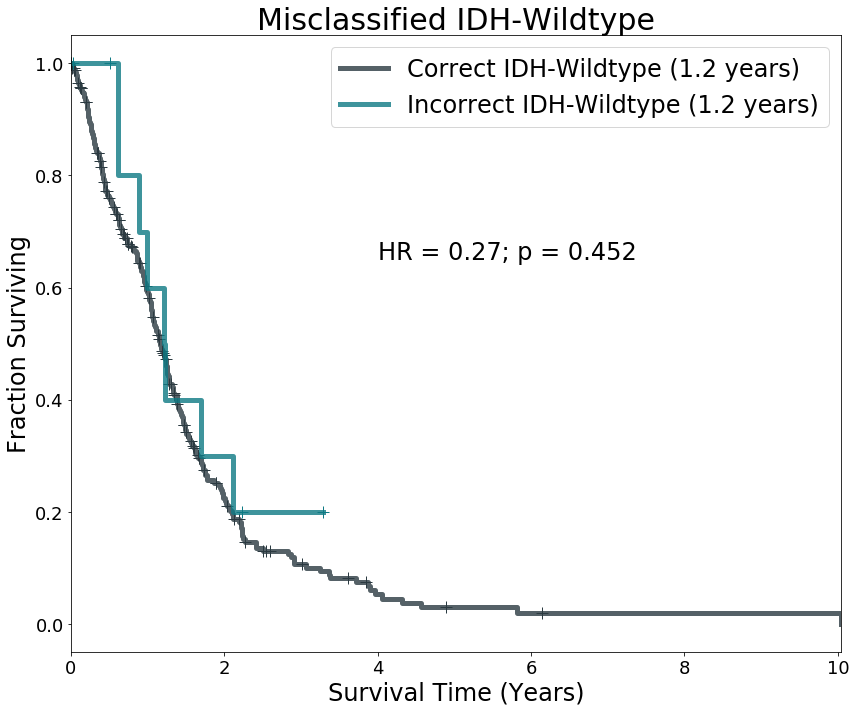

,p-value
"('Correct IDH-Wildtype', 'Incorrect IDH-Wildtype')",0.451965


In [22]:
save = False; outfile = None

error_thresh = 0.5
correct_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index.tolist()
incorrect_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index.tolist()

idxs = correct_wt_idxs + incorrect_wt_idxs
label_df = pd.DataFrame(index=idxs, columns=['label'])
label_df.loc[correct_wt_idxs, 'label'] = 'Correct IDH-Wildtype'
label_df.loc[incorrect_wt_idxs, 'label'] = 'Incorrect IDH-Wildtype'
exclude_labels = []

temp_style_dict = {}
temp_style_dict['Correct IDH-Wildtype'] = {'color': color_dict['c_wt'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}
temp_style_dict['Incorrect IDH-Wildtype'] = {'color': color_dict['w_wt'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}

title = 'Misclassified IDH-Wildtype'
kmf_df = pd.concat([tcga_clinical_df[['OS', 'OS_EVENT']], label_df], axis=1, join='inner')

save, outfile = False, None
result_df = survival_curves(kmf_df, 
                            title=title, 
                            save=save, 
                            outfile=outfile, 
                            show_p_value=True,
                            text_xpos=4, 
                            p_size=24,
                            text_ypos=0.65,
                            ci_show=False,
                            legend_size=24,
                            show_longtail=False,
                            exclude_labels=exclude_labels,
                            p_longtail=0.2,
                            pval_dec=3,
                            style_dict=temp_style_dict,
                            figsize=(12,10),
                            hr_replace_dict={'Incorrect IDH-Wildtype':0, 'Correct IDH-Wildtype':1},
                            titlesize=30,
                            show_hr=True)
get_pairwise_p_values(result_df['kmf'])